In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
pip install catboost

In [71]:
train=pd.read_csv("/content/drive/MyDrive/dsn house pricing/Housing_dataset_train.csv",index_col=0)
test=pd.read_csv("/content/drive/MyDrive/dsn house pricing/Housing_dataset_test.csv",index_col=0)

In [72]:
train.columns

Index(['loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')

<Axes: xlabel='parking_space', ylabel='price'>

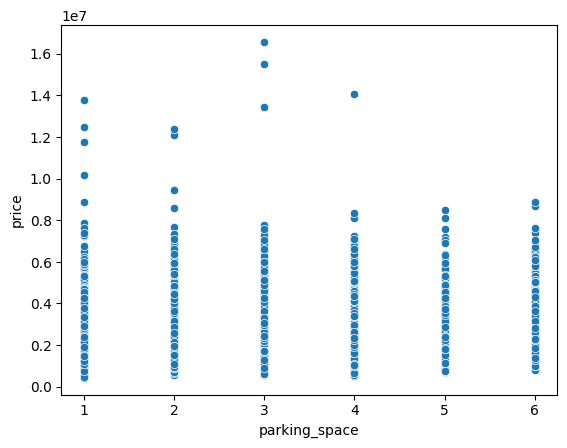

In [73]:
sns.scatterplot(x=train["parking_space"],y=train["price"])

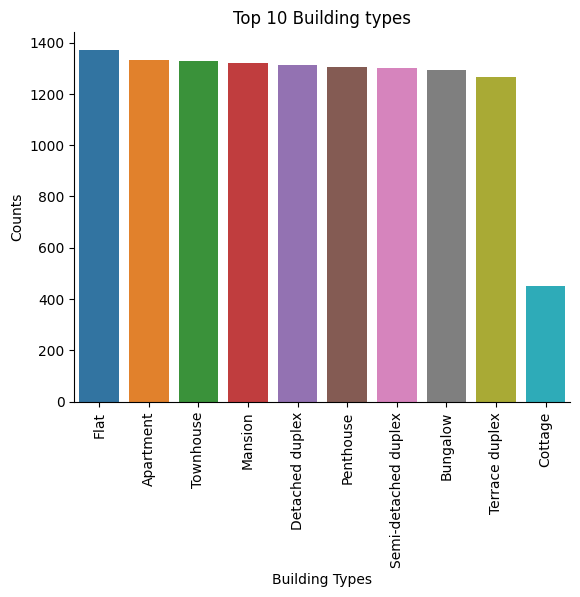

In [74]:
sns.barplot(x=train["title"].value_counts().index[:10], y=train["title"].value_counts()[:10])

# Add labels and title
plt.xlabel('Building Types')
plt.ylabel('Counts')
plt.title('Top 10 Building types')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=90)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

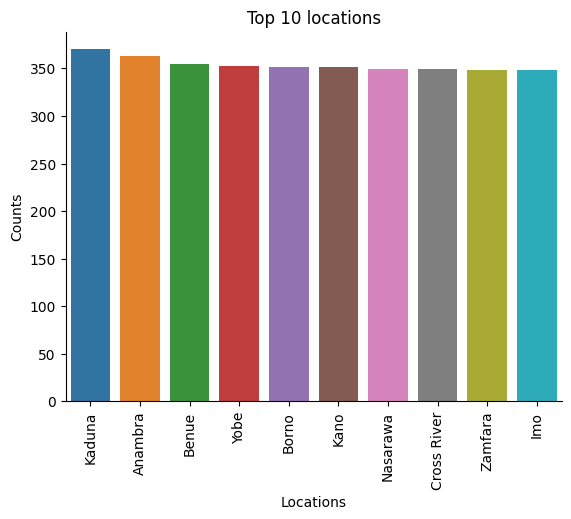

In [75]:
sns.barplot(x=train["loc"].value_counts().index[:10], y=train["loc"].value_counts()[:10])

# Add labels and title
plt.xlabel('Locations')
plt.ylabel('Counts')
plt.title('Top 10 locations')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=90)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


# Show the plot
plt.show()

In [77]:
train["bed per bath"]=train["bathroom"]/train["bedroom"]
test["bed per bath"]=test["bathroom"]/test["bedroom"]

train["bed per park"]=train["parking_space"]/train["bedroom"]
test["bed per parkh"]=test["parking_space"]/test["bedroom"]

In [78]:
all_data=pd.concat([train,test])

In [79]:
for i in all_data.columns:
  if all_data[i].dtype=="object":
    all_data[i]=pd.factorize(all_data[i])[0]

In [80]:
train=all_data[:train.shape[0]]
test=all_data[train.shape[0]:]

In [81]:
target=train["price"]
train.drop("price",axis=1,inplace=True)

<ipython-input-81-6b8e41724204>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop("price",axis=1,inplace=True)


In [82]:
from sklearn.model_selection import train_test_split

In [83]:
X,val,y,y_val=train_test_split(train, target,test_size=0.15,random_state=0)

In [84]:
from catboost import CatBoostRegressor

In [85]:
model=CatBoostRegressor()

In [86]:
model.fit(X,y,eval_set=(val,y_val))

Learning rate set to 0.07512
0:	learn: 1056934.6233300	test: 1038839.3311330	best: 1038839.3311330 (0)	total: 8.01ms	remaining: 8s
1:	learn: 1019207.5269374	test: 1002588.6862797	best: 1002588.6862797 (1)	total: 22.9ms	remaining: 11.4s
2:	learn: 998527.9937658	test: 983473.5563141	best: 983473.5563141 (2)	total: 27.5ms	remaining: 9.15s
3:	learn: 965836.0376005	test: 952188.5187541	best: 952188.5187541 (3)	total: 30.3ms	remaining: 7.55s
4:	learn: 934689.0000941	test: 922186.0070387	best: 922186.0070387 (4)	total: 33.4ms	remaining: 6.64s
5:	learn: 908877.7254667	test: 897785.7064240	best: 897785.7064240 (5)	total: 38.4ms	remaining: 6.35s
6:	learn: 893152.3077911	test: 883272.8642290	best: 883272.8642290 (6)	total: 41.1ms	remaining: 5.84s
7:	learn: 870250.6930918	test: 861466.6370797	best: 861466.6370797 (7)	total: 44.4ms	remaining: 5.5s
8:	learn: 857788.8563314	test: 850337.4507095	best: 850337.4507095 (8)	total: 46.8ms	remaining: 5.16s
9:	learn: 843657.6288350	test: 836928.3643430	best:

In [87]:
predictions=model.predict(test)
sub=pd.DataFrame({"ID":test.index,"price": predictions}).set_index("ID")
sub.to_csv("submission_house_price.csv")

In [88]:
from sklearn.metrics import mean_squared_error

In [89]:
mean_squared_error(y_val,model.predict(val),squared=False)

535259.864482706

In [90]:
mean_squared_error(y,model.predict(X),squared=False)

475822.9219231334

In [91]:
from sklearn.model_selection import KFold

folds=KFold(n_splits=8,shuffle=True,random_state=0)
predictions_df=pd.DataFrame()
rmse_val=[]
rmse_X=[]
model=CatBoostRegressor(verbose=0,random_state=0)
for i,(train_index,test_index) in enumerate(folds.split(train,target)):
    train_fold=train.iloc[train_index]
    val_fold=train.iloc[test_index]
    y_fold=target.iloc[train_index]
    y_val_fold=target.iloc[test_index]
    model.fit(train_fold,y_fold)
    print(i)
    prediction=model.predict(test)
    predictions_df[i]=prediction
    rmse_val.append(mean_squared_error(model.predict(val_fold),y_val_fold,squared=False))
    rmse_X.append(mean_squared_error(model.predict(train_fold),y_fold,squared=False))
print(rmse_val)
print(rmse_X)

0
1
2
3
4
5
6
7
[534300.5624757713, 567705.8874911752, 491762.05887488276, 545492.022886124, 494634.2162675544, 482944.83885036793, 573908.3232436575, 581303.5321728454]
[428105.35063404083, 428020.5737348008, 437255.19289828534, 434220.20708971715, 436484.05674608203, 434428.4870922248, 425897.6867288576, 426678.82857473067]


In [92]:
predictions=predictions_df.mean(axis=1)
sub_kfold_mean=pd.DataFrame({"id":test.index,"Age":predictions}).set_index("id")
sub_kfold_mean.to_csv("submission_kfold_mean.csv")

In [93]:
predictions=predictions_df.median(axis=1)
sub_kfold_median=pd.DataFrame({"id":test.index,"Age":predictions}).set_index("id")
sub_kfold_median.to_csv("submission_kfold_median.csv")

In [94]:
imp=pd.DataFrame({"columns":X.columns,"importance":model.feature_importances_}).set_index("columns")

In [95]:
imp.sort_values("importance")

,importance
columns,
bed per parkh,0.000000
parking_space,1.868714
bed per park,2.395658
bed per bath,2.403430
bathroom,3.235804
bedroom,16.348109
loc,26.569545
title,47.178739


In [96]:
x=imp.sort_values("importance").index
y=imp.sort_values("importance")

In [97]:
y

,importance
columns,
bed per parkh,0.000000
parking_space,1.868714
bed per park,2.395658
bed per bath,2.403430
bathroom,3.235804
bedroom,16.348109
loc,26.569545
title,47.178739


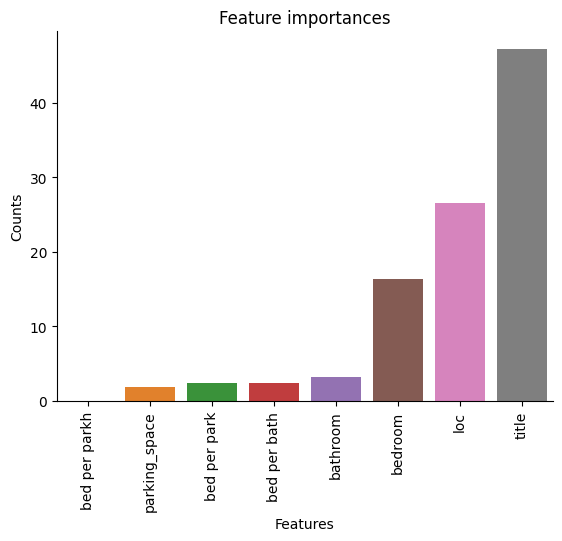

In [105]:
sns.barplot(x=x,y=y["importance"])
# Add labels and title
plt.xlabel('Features')
plt.ylabel('Counts')
plt.title('Feature importances')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=90)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()